# Homework 6: Permutation Testing, Percentiles, and Bootstrapping

## Due Saturday, February 26th at 11:59PM

Welcome to Homework 6! This homework will cover:

- Permutation Testing (see [Note 22](https://notes.dsc10.com/05-hypothesis_testing/2_permutation_tests.html) and [CIT 12](https://inferentialthinking.com/chapters/12/Comparing_Two_Samples.html))
- Percentiles (see [Note 24](https://notes.dsc10.com/06-estimation/2_confidence_intervals.html#percentiles))
- Bootstrapping and Confidence Intervals (see [Note 23](https://notes.dsc10.com/06-estimation/1_bootstrap.html), [Note 24](https://notes.dsc10.com/06-estimation/2_confidence_intervals.html), and [Note 25](https://notes.dsc10.com/06-estimation/3_ht_using_intervals.html))

### Instructions

This assignment is due Saturday, February 26th at 11:59pm. You are given six slip days thoughout the quarter to extend deadlines. See the syllabus for more details. With the exception of using slip days, late work will not be accepted unless you have made special arrangements with your instructor.

**Important**: For homeworks, the `otter` tests don't usually tell you that your answer is correct. More often, they help catch careless mistakes. It's up to you to ensure that your answer is correct. If you're not sure, ask someone (not for the answer, but for some guidance about your approach). These are great questions for office hours (see the schedule on the [Calendar](https://dsc10.com/calendar)) or Campuswire. Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

In [ ]:
# Don't change this cell; just run it. 
import babypandas as bpd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import otter
grader = otter.Notebook()

## 1. Lyft and Uber Rides in Boston 🚕📱🍀

In this section, we will work with a dataset of rideshare data from [Kaggle](https://www.kaggle.com/ravi72munde/uber-lyft-cab-prices?select=cab_rides.csv). The dataset contains information on Lyft and Uber rides from Boston during November and December of 2018. The data has been cleaned and condensed for the purposes of this question.

The rideshare data contains six columns: `'app'`, `'mode'`, `'destination'`, `'source'`, `'distance'`, `'price'`. Let's read it in and store it in the variable name `rideshare`.

| Column | Description |
| --- | --- |
| `'app'` | Rideshare App (Lyft or Uber) |
| `'mode'` | Ride tier/mode |
| `'destination'` | Destination area in Boston |
| `'source'` | Ride origin area in Boston |
| `'distance'` | Ride distance (miles) |
| `'price'` | Ride price (USD) |

In [ ]:
rideshare = bpd.read_csv('data/rideshare_boston.csv')
rideshare

**Question 1.1**. The `'mode'` column contains several categories, which represent the ride tiers. A ride tier is an option for the type of car you're requesting. For example, when you request an Uber, you have several options: UberX (regular), UberXL (SUV), Uber Pool (shared), etc. The prices will differ for each ride mode.

Below, assign `lyft_modes` to a **list** of the names of all unique Lyft ride modes, and `uber_modes` to a **list** of the names of all unique Uber ride modes.

**_Hint 1:_** While you could use `np.unique`, there's a way to approach this problem strictly using techniques from lecture.

**_Hint 2:_** Use the function `list` to convert an array/Series/index to a list.

In [ ]:
lyft_modes = ...
uber_modes = ...

# Don't change the following two lines:
print('lyft_modes:', lyft_modes)
print('uber_modes:', uber_modes)
# lyft_modes, uber_modes

In [ ]:
grader.check("q1_1")

For the next few problems, we will be working with base Lyft and UberX rides, since they are the most commonly used ride tiers for each company. Run the next cell to query only the base Lyft rides and UberX rides. We are saving these rides in a DataFrame called `economy_rides`.

In [ ]:
lyft_base = (rideshare.get('app') == 'Lyft') & (rideshare.get('mode') == 'Lyft')
uber_x = (rideshare.get('app') == 'Uber') & (rideshare.get('mode') == 'UberX')
economy_rides = rideshare[lyft_base | uber_x].reset_index(drop=True)
economy_rides

Moving forward, "Lyft" will refer to base Lyft rides, and "Uber" will refer to UberX rides.

**Question 1.2**. To compare the price of Lyft rides and Uber rides, let’s find the price per mile for each ride. For example, a ride that cost \\$10 and that drove a distance of 2.5 miles has a price per mile of $\frac{10}{2.5}$ = \\$4 per mile.

In the `economy_rides` DataFrame, create a new column named `'price_per_mile'` which contains the price per mile for each ride. Then, find the min, max, mean, and median `'price_per_mile'` of all rides in `economy_rides`, and save these values **in this order** in an *array* called `price_stats`.

In [ ]:
economy_rides = ...
price_stats = ...
price_stats

In [ ]:
grader.check("q1_2")

**Question 1.3.** Using the `economy_rides` DataFrame, calculate the difference between the **mean** `'price_per_mile'` of Lyft rides and Uber rides. Assign your answer to `observed_difference`.

$$\text{observed difference} = \text{mean Lyft price per mile} - \text{mean Uber price per mile}$$

In [ ]:
observed_difference = ...
observed_difference

In [ ]:
grader.check("q1_3")

**Question 1.4.** Interpret in words the number you obtained for `observed_difference` and assign either 1, 2, 3, or 4 to `q1_4`.

1. In our sample, the mean Lyft price per mile is lower than the mean Uber price per mile by about 44 percent.
2. In our sample, the mean Lyft price per mile is higher than the mean Uber price per mile by about 44 percent.
3. In our sample, the mean Lyft price per mile is lower than the mean Uber price per mile by about 0.44 dollars per mile.
4. In our sample, the mean Uber price per mile is lower than the mean Lyft price per mile by about 0.44 dollars per mile.

In [ ]:
q1_4 = ...

In [ ]:
grader.check("q1_4")

Now we want to conduct a permutation test (i.e. an A/B test) to see if it is by chance that the average price per mile for Lyft rides is less than average price per mile for Uber rides in our sample, or if Lyft rides really are cheaper per mile on average than Uber rides. 

- **Null Hypothesis:** The prices per mile of Lyft rides and Uber rides come from the same distribution.  
- **Alternative Hypothesis:** The prices per mile of Lyft rides are lower on average than the prices per mile of Uber rides.

**Question 1.5.** Assign `lyft_uber_price` to a DataFrame with only two columns, `'app'` and `'price_per_mile'`. These are the only relevant columns in `economy_rides` for this permutation test.

<!--
BEGIN QUESTION
name: q1_5
-->

In [ ]:
lyft_uber_price = ...
lyft_uber_price

In [ ]:
grader.check("q1_5")

**Question 1.6.** To perform the permutation test, 500 times, create two random groups by shuffling the `'app'` column of `lyft_uber_price`. Don't change the `'price_per_mile'` column. For each pair of random groups, calculate the difference in mean price per mile (Lyft minus Uber) and store your 500 differences in the `differences` **array**.  

**_Note:_** Since we are working with a relatively large data set, it may take over a minute to generate 500 permutations. One suggestion is to make sure your code works correctly with fewer repetitions, say, 20, before using 500 repetitions.

In [ ]:
differences = ...
...

# Just display the first ten differences.
differences[:10]

In [ ]:
grader.check("q1_6")

**Question 1.7.** Compute a p-value for this hypothesis test and assign your answer to `p_val`. To decide whether to use `<=` or `>=` in the calculation of the p-value, think about whether larger values or smaller values of our test statistic favor the alternative hypothesis.

In [ ]:
p_val = ...
p_val

In [ ]:
grader.check("q1_7")

**Question 1.8.** Assign the variable `q1_8` to a **list** of all the true statements below.

1. We reject the null hypothesis at the 0.01 significance level.
2. We fail to reject the null hypothesis at the 0.01 significance level.
3. We accept the null hypothesis at the 0.01 significance level.
4. We reject the null hypothesis at the 0.05 significance level.
5. We fail to reject the null hypothesis at the 0.05 significance level.
6. We accept the null hypothesis at the 0.05 significance level.

In [ ]:
q1_8 = ...

In [ ]:
grader.check("q1_8")

**Question 1.9.** Which of the following choices best describes the purpose of shuffling the data in a permutation test? Assign either 1, 2, or 3 to `q1_9`.
1. Shuffling is a special case of bootstrapping and allows us to produce interval estimates.
2. Shuffling allows us to generate new data under the alternative hypothesis, which explains that the data come from different distributions.
3. Shuffling allows us to generate new data under the null hypothesis, which we can use in testing our hypothesis.
4. Shuffling mitigates noise in our data by generating new permutations of the data.

In [ ]:
q1_9 = ...

In [ ]:
grader.check("q1_9")

**Question 1.10.** Suppose in this question you had shuffled the `'price_per_mile'` column instead and kept the `'app'` column in the same order. Which of the following is a true statement? Assign `q1_10` to either 1, 2, 3, or 4.


1. The new p-value from shuffling `'price_per_mile'` would be $1 - p$, where $p$ is the old p-value from shuffling `'app'` (i.e. your answer to Question 1.7).
2. There would be no difference in the conclusion of the test if we had shuffled the `'price_per_mile'` column instead.
3. The `'price_per_mile'` column cannot be shuffled because it contains numbers.
4. We would need to change our null hypothesis in order to shuffle the `'price_per_mile'` column. 

In [ ]:
q1_10 = ...

In [ ]:
grader.check("q1_10")

## 2. Percentiles at Starbucks ☕

Percentiles associate numbers in a dataset to their positions when the dataset is sorted in ascending order.

Given any sequence (i.e. list, array, or Series) of numerical values, imagine sorting the values in ascending order, to create a ranked sequence. Roughly speaking, the $p$th percentile of this sequence is the value that is $p$ percent of the way through the sequence. For example, the 10th percentile is only 10% of the way through (towards the beginning), the 50th percentile is halfway through (towards the middle), and the 90th percentile is 90% of the way through (towards the end).

There are many different ways to precisely define a percentile. In this class, we'll consider two different approaches. You should think of these as two separate, different ways to define a percentile. They don't always agree!

### The mathematical definition

> Let $p$ be a number between 0 and 100. The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 

By this definition, any percentile between 0 and 100 can be computed for any collection of values and is always an element of the collection. 

Suppose there are $n$ elements in the collection. To find the $p$th percentile:

1. Sort the collection in increasing order.
2. Define $h$ to be $p\%$ of $n$: 

$$h = \frac p{100} \cdot n$$

3. If $h$ is an integer, define $k = h$. Otherwise, let $k$ be the smallest integer greater than $h$.

4. Take the $k$th element of the sorted collection
    - Start counting from 1, not 0.

### The `numpy` definition

- The `numpy` package provides a function to calculate percentiles, `np.percentile(array, p)`, which returns the `p`th percentile of `array`.
- The `numpy` method of calculating percentile is slightly different than ours.
    - The result need not be an element of the array. 
    - Details are unimportant, just know that our mathematical definition does not always match `np.percentile`!

The file `starbucks.csv` contains some nutritional information on menu items at Starbucks. The data comes from [Kaggle](https://www.kaggle.com/starbucks/starbucks-menu?select=starbucks_drinkMenu_expanded.csv). The columns include `'Category'`, `'Beverage'`, `'Calories'`, `'Total Fat (g)'`, `'Total Carbohydrates (g)'`, `'Sugars (g)'`, `'Protein (g)'`.

In [ ]:
starbucks = bpd.read_csv('data/starbucks.csv')
starbucks

**Question 2.1.** Pick the appropriate bins to plot a histogram showing the distribution of `'Total Carbohydrates (g)'`, then create the histogram.

Use one of the following:

- `carb_bins` = `np.arange(0, 40, 50)`
- `carb_bins` = `np.arange(0, 400, 50)`
- `carb_bins` = `np.arange(0, 4000, 50)`
- `carb_bins` = `np.arange(0, 40000, 50)`

In [ ]:
carb_bins = ...

# Now create a density histogram showing the distribution of 'Total Carbohydrates (g)' that uses carb_bins

**Question 2.2.** Consider only the Espresso drinks prepared with soy milk.

In [ ]:
soy_milk_espresso = (starbucks[(starbucks.get('Category').str.contains('Espresso')) \
                             & (starbucks.get('Beverage_prep') == 'Soymilk')] )
soy_milk_espresso

Let's extract the `'Total Carbohydrates (g)'` data for these soy milk Espressos and store them as an array called `esp_carbs`. We'll sort the array, too.

In [ ]:
esp_carbs = np.array(soy_milk_espresso.get('Total Carbohydrates (g)'))
esp_carbs = np.sort(esp_carbs)
esp_carbs

Let's calculate the 70th percentile of `esp_carbs` using the **mathematical definition** given above. Set `n` to be the number of elements in `esp_carbs`. Set `k` to be the smallest integer greater than $\frac {70}{100} \cdot n$. Assign the 70th percentile of the array `esp_carbs` to `seventieth_percentile_esp`.

You must use the variables provided for you when solving this problem. For this problem, **do not** use `np.percentile()`.

**_Hint:_** `np.ceil` will round up a number to the next nearest whole number.

In [ ]:
n = ...
k = ...

# Don't change this. In order to proceed, k needs to be stored as an int, not a float.
# This line is not changing the mathematical value of k, just how it is stored.
k = int(k)

seventieth_percentile_esp = ...
seventieth_percentile_esp

In [ ]:
grader.check("q2_2")

**Question 2.3.** Now we'll compare the 70th percentile of the total carbohydrates in **soy milk Espresso** beverages with the 70th percentile of total carbohydrates in **coffee beverages**.

Create a DataFrame called `coffee` containing only the beverages with a `'Category'` of `'Coffee'`. Calculate the 70th percentile of carbohydrates in these beverages, using the same mathematical procedure, and assign to the variable `absolute_difference` the absolute difference in the 70th percentile of carbohydrates for soy milk Espressos and coffee.

As before, use the variables provided and **do not** use `np.percentile()`.

**_Hint:_**  Remember to sort the calories using `np.sort` before computing percentiles.

In [ ]:
coffee = ...

n_2 = ...
k_2 = ...

k_2 = int(k_2) # Don't change this.

seventieth_percentile_coffee = ...

absolute_difference = ...
absolute_difference

In [ ]:
grader.check("q2_3")

**Question 2.4.** Say that Starbucks wants to create a new soy milk Espresso beverage for the Winter Olympics called the "Faster, Higher, Stronger Espresso" in honor of the Olympic Motto. This beverage will have 91 grams of carbohydrates, one gram for every participating nation this year.

Consider a new collection of values, containing all the values in `esp_carbs`, plus one more, 91:

In [ ]:
new_collection = np.append(esp_carbs, 91)
new_collection = np.sort(new_collection)
new_collection

For what integer values of $p$ would we be able to say that this new collection of values has 91 as its $p$th percentile? Create a **list** called `percentile_range` of all integer values of $p$ such that the $p$th percentile of the new collection equals 91, according to the **mathematical** definition of percentile. 

**Do not use `np.percentile()`.**

In [ ]:
percentile_range = ...

In [ ]:
grader.check("q2_4")

**Question 2.5**. The first quartile of a numerical collection is the 25th percentile, the second quartile is the 50th percentile, and the third quartile is the 75th percentile. Quartiles are so named because they divide the collection into quarters.

Make a list called `carb_quartiles` that contains the values for the first, second, and third quartiles (in that order) of the `'Total Carbohydrates (g)'` data provided in `starbucks`. For this problem, calculate the percentiles **using `np.percentile()`**.

In [ ]:
carb_quartiles = ...
carb_quartiles

In [ ]:
grader.check("q2_5")

## 3. Late Night Nuggets 🌙

Suppose you are a chicken nugget lover and a regular at McDonald's (especially late at night). When you go with your brother to get your third 4 piece Chicken McNuggets order of the week, you notice that one of your nuggets is extremely small. You start to wonder if you're better off getting your nuggets from Wendy's instead. Your brother tells you that McDonald's nuggets have always been this small, but you are doubtful and decide to investigate.

**Question 3.1.** Ideally, you would want to figure out the exact mean weight of *all* McDonald's nuggets. However, it's not feasible to do so. Therefore, you want to collect a sample of McDonald nuggets to obtain a ____________ statistic to estimate the ____________ parameter.

Complete the sentence above by filling in the blanks. Set `q3_1` to 1, 2, 3, or 4.

1. population; sample
2. sample; population
3. test; population
4. test; sample

In [ ]:
q3_1 = ...

In [ ]:
grader.check("q3_1")

Fortunately, you have a friend named Donald who works at McDonald's. He agrees to weigh 30 nuggets during his shift. Even better, you have another friend named Wendy who works at Wendy's. She agrees to weigh 30 nuggets during her shift at Wendy's.  Let's look at all the data that Donald and Wendy collected. Each entry represents the weight of one nugget, in grams.

**_Note:_** While the story about this data is obviously made-up, [the data is real](https://www.kaggle.com/michigan2000/weight-of-chicken-nuggets). Actual chicken nuggets from McDonald's and Wendy's were weighed! 🐥

In [ ]:
nugget_data = bpd.read_csv('data/nuggets.csv')
nugget_data

**Question 3.2.** The first few tasks we'll look at will only involve the nuggets in our sample from McDonald's. Below, assign `mcd_only` to a DataFrame with only the nuggets in our sample from McDonald's. Then, assign `mcd_mean` to the mean weight of the McDonald's nuggets in our sample.

In [ ]:
mcd_only = ...
mcd_mean = ...
mcd_mean

In [ ]:
grader.check("q3_2")

You're done! Or are you? You have a single estimate (called a *point estimate*) for the true mean weight of McDonald's nuggets. However, you don't know how accurate your estimate is, and you don't know how much your estimate could have varied, had you started with a different sample. In other words, you have an estimate, but you don't have a sense of how good that estimate is. 

This is where the idea of resampling via the [bootstrap](https://notes.dsc10.com/06-estimation/1_bootstrap.html#the-bootstrap) comes in. Let's assume that our original sample resembles the population fairly well. We can then resample from our original sample to produce even more samples. From each of these resamples, we can produce another estimate, which gives us a whole distribution of how the estimate might have turned out if our sample were different. We can then use this distribution to produce an interval estimate for the true mean weight of McDonald's nuggets.

**Question 3.3.** Complete the following code to produce 1000 bootstrapped estimates for the  *mean* weight of McDonald's nuggets. Store your 1000 estimates in an array called `resample_means`.

In [ ]:
resample_means = ...
for i in np.arange(1000):
    resample = ...
    resample_mean = ...
    resample_means = ...
resample_means

In [ ]:
grader.check("q3_3")

Let's look at the distribution of your estimates:

In [ ]:
bpd.DataFrame().assign(BootstrappedMeans = resample_means).plot(kind='hist', density=True, ec='w', figsize=(10, 5));

**Question 3.4.** Using the array `resample_means`, compute an approximate 95% confidence interval for the true mean weight of McDonald's nuggets. Save the lower and upper bounds of the interval as `lower_bound_mcd` and `upper_bound_mcd`, respectively.

**_Hint:_** Use `np.percentile()`.

In [ ]:
lower_bound_mcd = ...
upper_bound_mcd = ...

#: the confidence interval
print("Bootstrapped 95% confidence interval for the true mean weight of McDonald's nuggets: [{:f}, {:f}]".format(lower_bound_mcd, upper_bound_mcd))

In [ ]:
grader.check("q3_4")

**Question 3.5.** Which of the following would make the histogram from Question 3.3 narrower? If you believe more than one would, choose the answer with the most substantial effect. Assign to `q3_5` either 1, 2, 3, or 4.
1. Starting with a larger sample of 60 nuggets.
2. Starting with a smaller sample of 15 nuggets.
3. Increasing the number of resamples (repetitions of the bootstrap) to 2000.
3. Decreasing the number of resamples (repetitions of the bootstrap) to 500.

In [ ]:
q3_5 = ...
q3_5

In [ ]:
grader.check("q3_5")

**Question 3.6.** Suppose you want to estimate the weight of the heaviest McDonald's nugget ever. Would bootstrapping be effective in estimating this weight? Assign `bootstrapping_effective` to either `True` or `False`, representing your answer.

In [ ]:
bootstrapping_effective = ...

In [ ]:
grader.check("q3_6")

**Question 3.7.** Now let's address a different question: how does the average weight of McDonald's nuggets compare to the average weight of Wendy's nuggets? Create a DataFrame called `wendys_only` that contains only the nuggets in our original sample from Wendy's, as you did for McDonald's in Question 3.2.  Then, set `observed_diff_mean` to the difference in mean nugget weight for the McDonald's and Wendy's nuggets in our sample (do McDonald's minus Wendy's).

In [ ]:
wendys_only = ...
observed_diff_mean = ...
observed_diff_mean

In [ ]:
grader.check("q3_7")

So there's definitely a difference in mean nugget weight between McDonald's and Wendy's for the 60 nuggets in our sample. But does this reflect a difference in mean nugget weight in the population, or was it just by chance that the nuggets in our sample displayed this difference? Let's do a hypothesis test to find out. We'll state our hypotheses as follows:

- **Null Hypothesis:** The mean weight of McDonald's nuggets equals the mean weight of Wendy's nuggets. Equivalently, the difference in the mean nugget weight for McDonald's and Wendy's equals 0 grams.

- **Alternative Hypothesis:** The mean weight of McDonald's nuggets does not equal the mean weight of Wendy's nuggets. Equivalently, the difference in the mean nugget weight for McDonald's and Wendy's does not equal 0 grams.

Since we were able to set up our hypothesis test as a question of whether a certain population parameter – the difference in mean nugget weight for McDonald's and Wendy's – is equal to a certain value, we can **test our hypotheses by constructing a confidence interval** for the parameter. This is the method we used in Lecture 20 to test whether the median salary of Fire-Rescue Department workers was the same as the median salary of all San Diego city employees. You can read more about conducting a hypothesis test with a confidence interval in [Note 25](https://notes.dsc10.com/06-estimation/3_ht_using_intervals.html).

**_Note:_** We are not conducting a permutation test here, although that would also be a valid approach to test these hypotheses.

**Question 3.8.** Compute 1000 bootstrapped estimates for the difference in the mean nugget weight for McDonald's and Wendy's (do McDonald's minus Wendy's). Store your 1000 estimates in the `difference_means` array.

You should generate your McDonald's resamples by sampling from `mcd_only`, and your Wendy's resamples by sampling from `wendys_only`. You should not use `nugget_data` at all.

In [ ]:
np.random.seed(23) # Don't change this!

difference_means = ...

# Just display the first ten differences.
difference_means[:10]

In [ ]:
grader.check("q3_8")

Let's visualize your estimates:

In [ ]:
bpd.DataFrame().assign(BootstrappedDifferenceMeans = difference_means).plot(kind = 'hist', density=True, ec='w', figsize=(10, 5));

**Question 3.9.** Compute a 95% confidence interval for the difference in mean weights of McDonald's and Wendy's nuggets (as before, McDonald's minus Wendy's). Assign the left and right endpoints of this confidence interval to `left_endpoint` and `right_endpoint` respectively. Use `np.percentile()` to find the endpoints.

In [ ]:
left_endpoint = ...
right_endpoint = ...

print("Bootstrapped 95% confidence interval for the mean difference in weights of McDonald's and Wendys nuggets:\n [{:f}, {:f}]".format(left_endpoint, right_endpoint))

In [ ]:
grader.check("q3_9")

**Question 3.10.** Based on the confidence interval you've created, would you reject the null hypothesis at the 0.05 significance level? Set `reject_null` to True if you would reject the null hypothesis, and False if you would not.

In [ ]:
reject_null = ...

In [ ]:
grader.check("q3_10")

**Question 3.11.** What if Donald and Wendy had recorded all of their data in pounds instead of grams? Would your hypothesis test still come to the same conclusion either way? Set `same_conclusion` to True or False.

In [ ]:
same_conclusion = ...

In [ ]:
grader.check("q3_11")

**Question 3.12.** Choose the best tool to test the following claim: <br>
> More people prefer McDonald's nuggets to Wendy's nuggets than the other way around.
1. standard hypothesis testing
2. permutation (A/B) testing
3. bootstrapping

Assign `q3_12` to either 1, 2, or 3 below.

**_Hint:_** Which example from lecture is this the most similar to?

In [ ]:
q3_12 = ...

In [ ]:
grader.check("q3_12")

**Question 3.13.** Which test statistic(s) could we use to test the claim from 3.12? Put all that are valid into a **list** called `q3_13`.
1. The number of people that prefer McDonald's divided by the total number of people, in a given random sample. 
2. The difference between the proportion of people that prefer McDonald's and the proportion of people that prefer Wendy's, in a given random sample.
3. The absolute difference between the proportion of people that prefer McDonald's and the proportion of people that prefer Wendy's, in a given random sample.
3. The total variation distance between the proportion of people that prefer McDonald's and the proportion of people that prefer Wendy's, in a given random sample.

In [ ]:
q3_13 = ...

In [ ]:
grader.check("q3_13")

**Question 3.14.** Choose the best tool to answer the following question: <br>
> What is the mean tip amount left by all Wendy's customers?
1. standard hypothesis testing
2. permutation (A/B) testing
3. bootstrapping

In [ ]:
q3_14 = ...

In [ ]:
grader.check("q3_14")

## 4. Cheese  🧀

You work for a small grocery store. You are interested in determining which types of cheese to stock in your store, so you survey 500 randomly-selected shoppers and ask which type of cheese they prefer the most, among four options (`'Brie'`, `'Cheddar'`, `'Feta'`, `'Mozzarella'`). You also record some indecisive shoppers as `'Undecided'`.

Run the next cell to load in the results of the survey.

In [ ]:
cheese = bpd.read_csv("data/cheese.csv")
cheese.reset_index().groupby('cheese').count()

Assume that your sample is a uniform random sample of the population of grocery store shoppers. Below, we compute the proportion of shoppers in your sample that prefer each type of cheese.

In [ ]:
cheese.assign(counts=cheese.get('cheese')).groupby('cheese').count().get('counts') / cheese.shape[0]

What you're truly interested in, though, is the proportion of *all shoppers* that prefer each type of cheese. These are *population parameters* (plural, because there are 5 proportions).

In this question, we will start by computing a confidence interval for the true proportion of shoppers that prefer `'Brie'`, and then later compute a confidence interval for the true difference in proportions of shoppers that prefer `'Brie'` over `'Cheddar'`. 

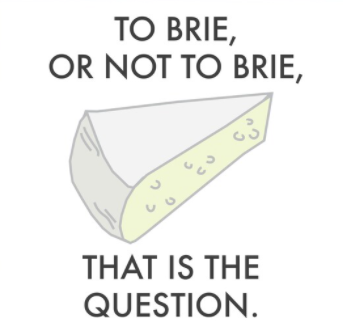

Below, we have given you code that uses bootstrapping to compute 1,000 estimates of the true proportion of shoppers who prefer `'Brie'` cheese. Run the next cell to calculate these estimates and display a histogram of their values.

In [ ]:
def proportions_in_resamples():
    np.random.seed(55) # Ignore this, and don't change it.
    num_shoppers = cheese.shape[0]
    proportions = np.array([])
    for i in np.arange(1000):
        resample = cheese.sample(num_shoppers, replace = True)
        resample_proportion = np.count_nonzero(resample.get('cheese') == 'Brie') / num_shoppers
        proportions = np.append(proportions, resample_proportion)
    return proportions

boot_brie_proportions = proportions_in_resamples()
bpd.DataFrame().assign(Estimated_Proportion_Brie=boot_brie_proportions).plot(kind='hist', density=True, ec='w', figsize=(10, 5));

**Question 4.1.** Using the array `boot_brie_proportions`, compute an approximate **99%** (not 95%) confidence interval for the true proportion of shoppers who prefer `'Brie'` cheese.  Compute the lower and upper ends of the interval, named `brie_lower_bound` and `brie_upper_bound`, respectively.

In [ ]:
brie_lower_bound = ...
brie_upper_bound = ...

# Print the confidence interval:
print("Bootstrapped 99% confidence interval for the true proportion of shoppers who prefer Brie cheese in the population:\n[{:f}, {:f}]".format(brie_lower_bound, brie_upper_bound))

In [ ]:
grader.check("q4_1")

**Question 4.2.**
Is it true that 99% of the population lies in the range `brie_lower_bound` to `brie_upper_bound`? Assign the variable `q4_2` to either `True` or `False`. 

In [ ]:
q4_2 = ...

In [ ]:
grader.check("q4_2")

**Question 4.3.**
Is it true that the true proportion of shoppers who prefer `'Brie'` is a random quantity with approximately a 99% chance of falling between `brie_lower_bound` and `brie_upper_bound`? Assign the variable `q4_3` to either `True` or `False`.

In [ ]:
q4_3 = ...

In [ ]:
grader.check("q4_3")

**Question 4.4.**
Suppose we were somehow able to produce 20,000 new samples, each one a uniform random sample of 1,000 shoppers taken directly from the population. For each of those 20,000 new samples, we create a 99% confidence interval for the proportion of shoppers who prefer `'Brie'`. Roughly how many of those 20,000 intervals should we expect to actually contain the true proportion of the population? Assign your answer to the variable `how_many` below. It should be of type `int`, representing the *number* of intervals, not the proportion or percentage.

In [ ]:
how_many = ...
how_many

In [ ]:
grader.check("q4_4")

**Question 4.5.** We also created 90%, 95%, and 99.9% confidence intervals from one sample (shown below), but forgot to label which confidence intervals were which! Match the interval to the percent of confidence the interval represents and assign your choices (either 1, 2, or 3) to variables `ci_90`, `ci_95`, and `ci_999`, corresponding to the 90%, 95%, and 99.9% confidence intervals respectively.

**_Hint:_** Drawing the confidence intervals out on paper might help you visualize them better.

1. $[0.242, 0.320]$

2. $[0.246, 0.312]$

3. $[0.210, 0.348]$

In [ ]:
ci_90 = ...
ci_95 = ...
ci_999 = ...
ci_90, ci_95, ci_999

In [ ]:
grader.check("q4_5")

**Question 4.6.** Based on the survey results shown at the start of the question, it seems that `'Brie'` is more popular than `'Cheddar'` among shoppers. We would like to use confidence intervals to determine a range of likely values for the difference in popularity, which we define as:

$$\text{(Proportion of shoppers who prefer Brie)} - \text{(Proportion of shoppers who prefer Cheddar)}$$

Create a function, `differences_in_resamples`, that uses **bootstrapping to create 1,000 resamples of the original survey data** in the `cheese` DataFrame, computes the difference in proportions for each resample, and returns an array of these differences. Store your bootstrap estimates in an array called `boot_differences` and plot a histogram of these estimates.

**_Note:_** While this might sound like a job for permutation testing, this is instead a bootstrapping question. Note that our goal is to estimate a population parameter - the difference between the proportion of all shoppers that prefer Brie and the proportion of all shoppers that prefer Cheddar - not to answer a question about whether two samples come from the same distribution.

**_Hint_**: Use the code for `proportions_in_resamples` given to you above as a starting point.

In [ ]:
def differences_in_resamples():
    np.random.seed(55) # Ignore this, and don't change it.
    ...

boot_differences = ...

# Plot a histogram of boot_differences.

In [ ]:
grader.check("q4_6")

**Question 4.7.** Compute an approximate 99% confidence interval for the difference in proportions. Assign the lower and upper bounds of the interval to `diff_lower_bound` and `diff_upper_bound`, respectively.

In [ ]:
diff_lower_bound = ...
diff_upper_bound = ...

# Print the confidence interval:
print("Bootstrapped 99% confidence interval for the difference in popularity between Brie and Cheddar:\n[{:f}, {:f}]".format(diff_lower_bound, diff_upper_bound))

In [ ]:
grader.check("q4_7")

## Finish Line 🏁

Congratulations! You are done with Homework 6 – the second-last homework of the quarter!

To submit your assignment:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
2. Read through the notebook to make sure everything is fine and all tests passed.
3. Run the cell below to run all tests, and make sure that they all pass.
4. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope.

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
grader.check_all()